In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,ElasticNet
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score,mean_absolute_error
from  sklearn.feature_selection import VarianceThreshold
from warnings import filterwarnings
filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputRegressor


### Dataset split

- **Splitting method:** We used the train_test_split function from sklearn.model_selection to split the dataset into training and testing sets. We used a 70/30 split, meaning that 70% of the dataset was used for training and 30% for testing.


In [14]:
# read the data
data = pd.read_csv("random_forest.csv")

# select the features and targets
features = ['num_samples', 'num_features', 'dataset_size']
targets = ['Memory Usage','Total Time']


# assign the features and targets to X and y
X = data[features]
y = data[targets]

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#### Pipeline

- **Pipeline:** We created a pipeline that applies the data preprocessing steps and then fits the model to the training data.

In [15]:
# create pipelines for all the models

# pipeline for random forest regressor
RandomForestRegressor_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler()),
    ('variance', VarianceThreshold()),
    ('model', MultiOutputRegressor(RandomForestRegressor()))
])

# pipeline for linear regression model
LinearRegression_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler()),
    ('variance', VarianceThreshold()),
    ('model', MultiOutputRegressor(LinearRegression()))
])

# pipeline for elastic net model
ElasticNet_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler()),
    ('variance', VarianceThreshold()),
    ('model', MultiOutputRegressor(ElasticNet()))
])

# pipeline for GradientBoostingRegressor model
GradientBoostingRegressor_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler()),
    ('variance', VarianceThreshold()),
    ('model', MultiOutputRegressor(GradientBoostingRegressor()))
])



- **Parameter Grid:** We used a parameter grid to search for the best parameters for each of the models. We used the GridSearchCV function from sklearn.model_selection to search for the best parameters. We used the following parameters for each model:

    - **Random Forest:** We used the following parameters for the random forest model: n_estimators, max_depth, max_features and criterion.

    - **Linear Regression:** We used the following parameters for the linear regression model: fit_intercept, normalize, and copy_X.

    - **Elastic Net:** We used the following parameters for the elastic net model: alpha, l1_ratio and max_iter.

    - **Gradient Boosting:** We used the following parameters for the gradient boosting model: n_estimators, learning_rate and max_depth

In [16]:
# list of parameter grid for all the models
param_grid = [
    {
        'model__estimator__n_estimators': [100, 200, 300],
        'model__estimator__max_depth': [5, 10, 15],
        'model__estimator__max_features': ['auto', 'sqrt', 'log2', None],
        'model__estimator__criterion': ['mse', 'mae'],
    },
    {
        'model__estimator__fit_intercept': [True, False],
        'model__estimator__normalize': [True, False],
        'model__estimator__copy_X': [True, False],
    },
    {
        'model__estimator__alpha': [0.1, 0.5, 1.0],
        'model__estimator__l1_ratio': [0.1, 0.5, 1.0],
        'model__estimator__max_iter': [100, 200, 300],
    },
    {
        'model__estimator__n_estimators': [100, 200, 300],
        'model__estimator__max_depth': [5, 10, 15],
        'model__estimator__learning_rate': [0.1, 0.05, 0.01],
    },
   
]

In [17]:


# create a dictionary of all the pipelines and their respective parameter grids
grid_dict = {   0: {'pipeline': RandomForestRegressor_pipeline, 'param_grid': param_grid[0]},
                1: {'pipeline': LinearRegression_pipeline, 'param_grid': param_grid[1]},
                2: {'pipeline': ElasticNet_pipeline, 'param_grid': param_grid[2]},
                3: {'pipeline': GradientBoostingRegressor_pipeline, 'param_grid': param_grid[3]},
            }


#### GridSearchCV

- **GridSearchCV:** We utilized the pipelines that we previously declared and we used GridSearchCV to find the optimal hyperparameters for each Regression model. 


In [ ]:

# Create a data_table df to store the results
data_table = pd.DataFrame(columns=['Regressor', 'Total Time_R2 Score', 'Total Time_MAE', 'Memory Usage_R2 Score', 'Memory Usage_MAE'])

# Grid search for all the pipelines
for i, (regressor, pipeline) in enumerate(grid_dict.items()):
    # create a grid search object
    grid = GridSearchCV(pipeline['pipeline'], param_grid=pipeline['param_grid'], cv=5, n_jobs=-1, verbose=1)
    # fit the grid search
    grid.fit(X_train, y_train)
    # do the predictions for the test set
    y_pred = grid.predict(X_test)

    # get the R2 score and mean absolute error for each target variable
    r2_score_total_time = r2_score(y_test['Total Time'], y_pred[:, 1])
    mae_total_time = mean_absolute_error(y_test['Total Time'], y_pred[:, 1])
    r2_score_memory_usage = r2_score(y_test['Memory Usage'], y_pred[:, 0])
    mae_memory_usage = mean_absolute_error(y_test['Memory Usage'], y_pred[:, 0])

    # add the results to the data_table dataframe
    data_table.loc[i] = [grid.best_estimator_.named_steps['model'].estimator.__class__.__name__, r2_score_total_time, mae_total_time, r2_score_memory_usage, mae_memory_usage]



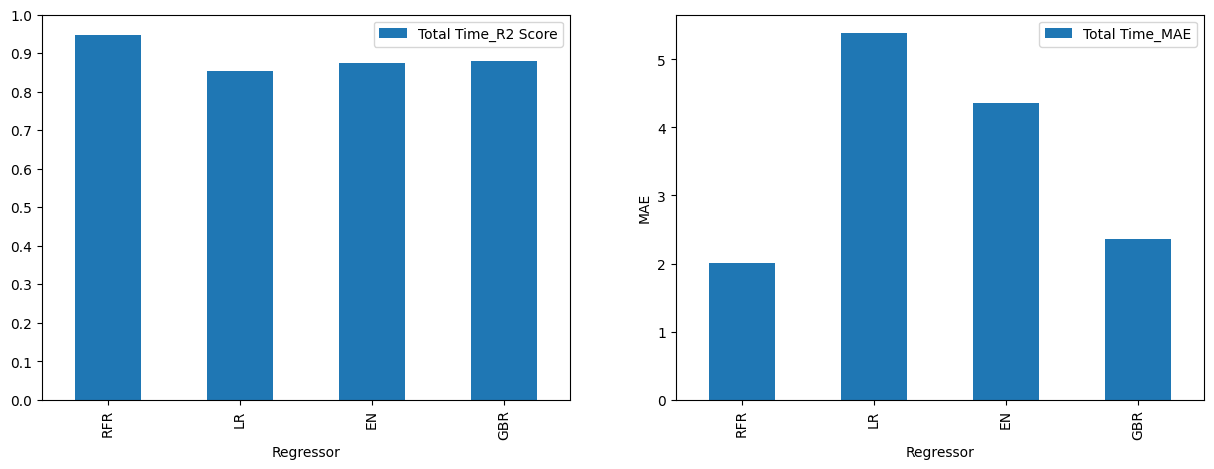

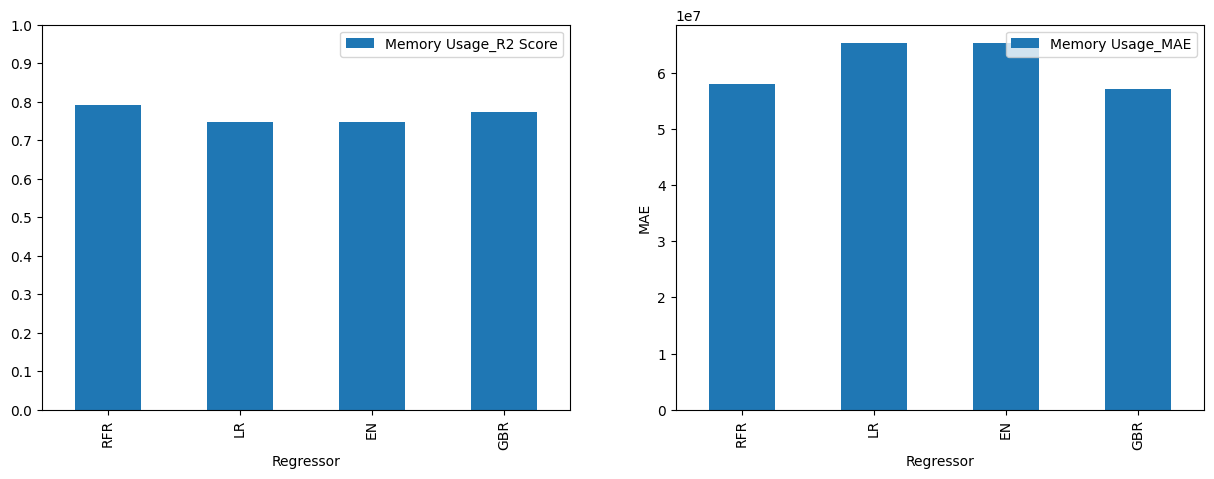

|    | Regressor   |   Total Time_R2 Score |   Total Time_MAE |   Memory Usage_R2 Score |   Memory Usage_MAE |
|---:|:------------|----------------------:|-----------------:|------------------------:|-------------------:|
|  0 | RFR         |              0.94674  |          2.00933 |                0.791883 |        5.80704e+07 |
|  1 | LR          |              0.853894 |          5.38523 |                0.74722  |        6.53183e+07 |
|  2 | EN          |              0.874765 |          4.35149 |                0.74722  |        6.53184e+07 |
|  3 | GBR         |              0.879968 |          2.35516 |                0.773481 |        5.71447e+07 |

In [19]:
from IPython.display import Markdown as md

name_map = {
    'RandomForestRegressor': 'RFR',
    'GradientBoostingRegressor': 'GBR',
    'LinearRegression': 'LR',
    'ElasticNet': 'EN',
}

# create a new column with the shorter names
data_table['Regressor'] = data_table['Regressor'].apply(lambda x: name_map.get(x, x))

# Display the results in a graph for Total Time R2 Score
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
data_table.plot(x='Regressor', y='Total Time_R2 Score', kind='bar', ax=ax[0])
plt.ylabel('R2 Score')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
ax[0].set_ylim([0,1])
ax[0].set_yticks(np.arange(0, 1.1, 0.1))

# Display the results in a graph for Total Time MAE
data_table.plot(x='Regressor', y='Total Time_MAE', kind='bar', ax=ax[1])
plt.ylabel('MAE')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)

plt.savefig('total_time_results.pdf', bbox_inches='tight')
plt.show()
# Display the results in a graph for Memory Usage R2 Score
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
data_table.plot(x='Regressor', y='Memory Usage_R2 Score', kind='bar', ax=ax[0])
plt.ylabel('R2 Score')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
ax[0].set_ylim([0,1])
ax[0].set_yticks(np.arange(0, 1.1, 0.1))

# Display the results in a graph for Memory Usage MAE
data_table.plot(x='Regressor', y='Memory Usage_MAE', kind='bar', ax=ax[1])
plt.ylabel('MAE')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)

plt.savefig('memory_results.pdf', bbox_inches='tight')
plt.show()



# display the results of the classifiers in a markdown table
markDownTableResults = data_table.to_markdown()
md(markDownTableResults)


#### Result analysis

- As we can see from the above results, the two Regressor models that have much better reults compared to the other models are the Random Forest Regressor and the Gradient Boosting Regressor. Both of them reach very high R2 scores and very low MAE, but the Random Forest Regressor is better than the Gradient Boosting Regressor. After running a significant number of tests, we found that the Random Forest Regressor has much more stable results among the different runs. For this reason, we decided to use the Random Forest Regressor as our final model.
